In [1]:
import xarray as xr
from math import sin, cos, sqrt, atan2, radians
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
from matplotlib import colors
from scipy import stats

In [2]:
home_folder = "/nethome/manra003/analysis/dispersion/simulations/"
# ds1 = xr.open_zarr(home_folder + "Fwd_2D_Luderitz_117x117_Nov01-31_2017_0z_100days.zarr")
# ds2 = xr.open_zarr(home_folder + "Fwd_3D_Luderitz_117x117_Nov01-31_2017_0z_100days.zarr")  
# ds3 = xr.open_zarr(home_folder + "Fwd_DVM_Luderitz_117x117_Nov01-31_2017_1z_100days.zarr") 
 
# ds1 = xr.open_zarr(home_folder + "Fwd_2D_Jul2023_BenguelaUpwR_117x117_Dec2017_1z_100days.zarr")
# ds2 = xr.open_zarr(home_folder + "Fwd_3D_Jul2023_BenguelaUpwR_117x117_Dec2017_1z_100days.zarr")  
# ds3 = xr.open_zarr(home_folder + "Fwd_DVM_Jul2023_BenguelaUpwR_117x117_Dec2017_1z_100days.zarr") 

ds1 = xr.open_zarr(home_folder + "08Aug2023_2D_BenguelaUpwR_pt2gridres_Dec2017_1z_100days_radius1mm_density1010.zarr")
ds2 = xr.open_zarr(home_folder + "08Aug2023_3D_BenguelaUpwR_pt2gridres_Dec2017_1z_100days_radius1mm_density1010.zarr")  
ds3 = xr.open_zarr(home_folder + "08Aug2023_DVM_BenguelaUpwR_pt2gridres_Dec2017_1z_100days_radius1mm_density1010.zarr") 
ds4 = xr.open_zarr(home_folder + "08Aug2023_3D_BP_BenguelaUpwR_pt2gridres_Dec2017_1z_100days_radius1mm_density1010.zarr") 


In [3]:
# Parallelised code from - Michael Denes
def distance(lon1, lat1, lon2, lat2, r=6378):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """

    #Convert decimal degrees to Radians:
    lon1 = np.radians(lon1)
    lat1 = np.radians(lat1)
    lon2 = np.radians(lon2)
    lat2 = np.radians(lat2)

    # if np.isnan([lon1, lon2, lat1, lat2]).any():
    #     return mask_value
    #Implementing Haversine Formula: 
    dlon = np.subtract(lon2, lon1)
    dlat = np.subtract(lat2, lat1)

    a = np.add(np.power(np.sin(np.divide(dlat, 2)), 2),  
                          np.multiply(np.cos(lat1), 
                                      np.multiply(np.cos(lat2), 
                                                  np.power(np.sin(np.divide(dlon, 2)), 2))))
    c = np.multiply(2, np.arcsin(np.sqrt(a)))

    return c*r

<h3> analyse distance from the initial release point to a given time (to understand why there is a big- quick spread between 2D and 3D simulation- white patches)

In [4]:
step=3
d1=distance(ds1['lon'][:, 0], ds1['lat'][:, 0], ds1['lon'][:, step], ds1['lat'][:, step])
fig=plt.figure(figsize=(6,6))
# plt.plot(d1, marker='o')
len(np.where(d1>111)[0])

11

<Figure size 432x432 with 0 Axes>

In [5]:
step=3
d1=distance(ds2['lon'][:, 0], ds2['lat'][:, 0], ds2['lon'][:, step], ds2['lat'][:, step])
fig=plt.figure(figsize=(6,6))
# plt.plot(d1, marker='o')
len(np.where(d1>111)[0])

11

<Figure size 432x432 with 0 Axes>

<h3> compute absolute distance between respective particles of different cases

In [6]:
t_days = 100
p_total = 2329

# Case 2D with all
sep_array_1_2 = np.empty((p_total, t_days))
sep_array_1_3 = np.empty((p_total, t_days))
sep_array_1_4 = np.empty((p_total, t_days))

# case 3D with remaining 2
sep_array_2_3 = np.empty((p_total, t_days))
sep_array_2_4 = np.empty((p_total, t_days))

# case DVM with remaining 1
sep_array_3_4 = np.empty((p_total, t_days))

sep_array_1_2[:] = np.nan
sep_array_1_3[:] = np.nan
sep_array_1_4[:] = np.nan

sep_array_2_3[:] = np.nan
sep_array_2_4[:] = np.nan

sep_array_3_4[:] = np.nan

# unreal_d = 99999.0
# sep_array_1_2 = np.full((p_total, t_days), unreal_d)
# sep_array_1_3 = np.full((p_total, t_days), unreal_d)
# sep_array_2_3 = np.full((p_total, t_days), unreal_d)


In [7]:
for time_step in range(t_days):
    sep_array_1_2[:, time_step] = distance(ds1['lon'][:, time_step], ds1['lat'][:, time_step], ds2['lon'][:, time_step], ds2['lat'][:, time_step])
    sep_array_1_3[:, time_step] = distance(ds1['lon'][:, time_step], ds1['lat'][:, time_step], ds3['lon'][:, time_step], ds3['lat'][:, time_step])
    sep_array_1_4[:, time_step] = distance(ds1['lon'][:, time_step], ds1['lat'][:, time_step], ds4['lon'][:, time_step], ds4['lat'][:, time_step])

    sep_array_2_3[:, time_step] = distance(ds2['lon'][:, time_step], ds2['lat'][:, time_step], ds3['lon'][:, time_step], ds3['lat'][:, time_step])
    sep_array_2_4[:, time_step] = distance(ds2['lon'][:, time_step], ds2['lat'][:, time_step], ds4['lon'][:, time_step], ds4['lat'][:, time_step])

    sep_array_3_4[:, time_step] = distance(ds3['lon'][:, time_step], ds3['lat'][:, time_step], ds4['lon'][:, time_step], ds4['lat'][:, time_step])

In [8]:
model_mask_file = '/storage/shared/oceanparcels/input_data/NEMO16_CMCC/GLOB16L98_mesh_mask_atlantic.nc'

mask_ds = xr.open_dataset(model_mask_file, decode_times=False).load()
mask_lon = mask_ds['glamf'].values
mask_lat = mask_ds['gphif'].values
mask_land = mask_ds['tmask'].values[:,:,:,:]

In [9]:
def get_axes(ax):
    custom_size=10
    gl = ax.gridlines(draw_labels=True)
    gl.xlines = False
    gl.ylines = False
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': custom_size, 'color': 'k'}
    gl.ylabel_style = {'size': custom_size, 'color': 'k'}

    colormap = colors.ListedColormap(['gainsboro', 'white'])

    ax.pcolormesh(mask_lon[0, 1249:1750, 1499:], mask_lat[0, 1249:1750, 1499:], mask_land[0, 0,1250:1750, 1500:], cmap=colormap)
    ax.set_xlim(0,17)
    ax.set_ylim(-30,-15)
    return ax

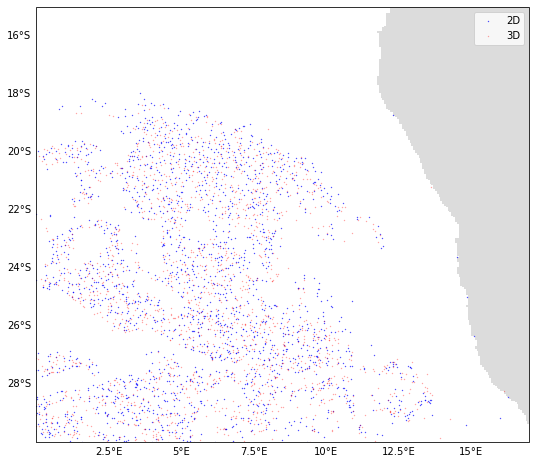

In [10]:
fig= plt.figure(figsize=(16, 8))
time_step= 100

ax = plt.axes(projection=ccrs.PlateCarree())
ax = get_axes(ax)
ax.scatter(ds1['lon'][:, time_step], ds1['lat'][:, time_step], s=0.1, c='blue',label="2D")
ax.scatter(ds2['lon'][:, time_step], ds2['lat'][:, time_step], s=0.1, c='red', label="3D", alpha=0.5)
ax.legend()

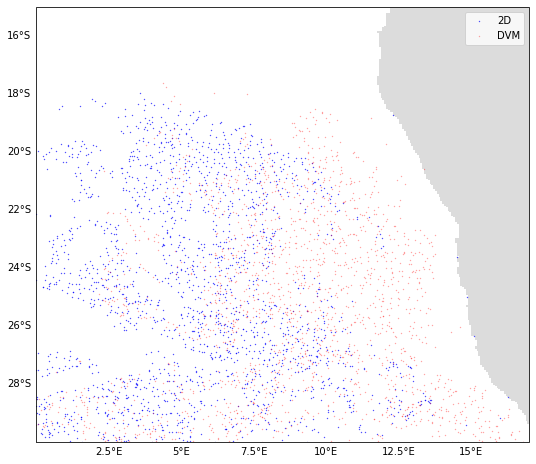

In [11]:
fig= plt.figure(figsize=(16, 8))

ax = plt.axes(projection=ccrs.PlateCarree())
ax = get_axes(ax)
ax.scatter(ds1['lon'][:, time_step], ds1['lat'][:, time_step], s=0.1, c='blue',label="2D")
ax.scatter(ds3['lon'][:, time_step], ds3['lat'][:, time_step], s=0.1, c='red', label="DVM", alpha=0.5)
ax.legend()

<h3> compute 95 percentile of particles distance for each day

In [12]:
t_step=99
print(min(sep_array_1_2[:,t_step]),max(sep_array_1_2[:,t_step]))
print(min(sep_array_1_3[:,t_step]),max(sep_array_1_3[:,t_step]))
print(min(sep_array_2_3[:,t_step]),max(sep_array_2_3[:,t_step]))

# assert np.equal(sep_array_1_2[:,t_step],sep_array_1_3[:,t_step]).all() 

percentile_95_1_2 = np.percentile(sep_array_1_2, 95, axis=0)
percentile_95_1_3 = np.percentile(sep_array_1_3, 95, axis=0)
percentile_95_2_3 = np.percentile(sep_array_2_3, 95, axis=0)

print(min(percentile_95_1_2),max(percentile_95_1_2))
print(min(percentile_95_1_3),max(percentile_95_1_3))
print(min(percentile_95_2_3),max(percentile_95_2_3))



0.0 1342.3696081322646
0.0 1460.8291209368303
0.0 1426.100242442674
0.0 230.14845900818565
0.0 508.1230218746581
0.0 491.95251610573223


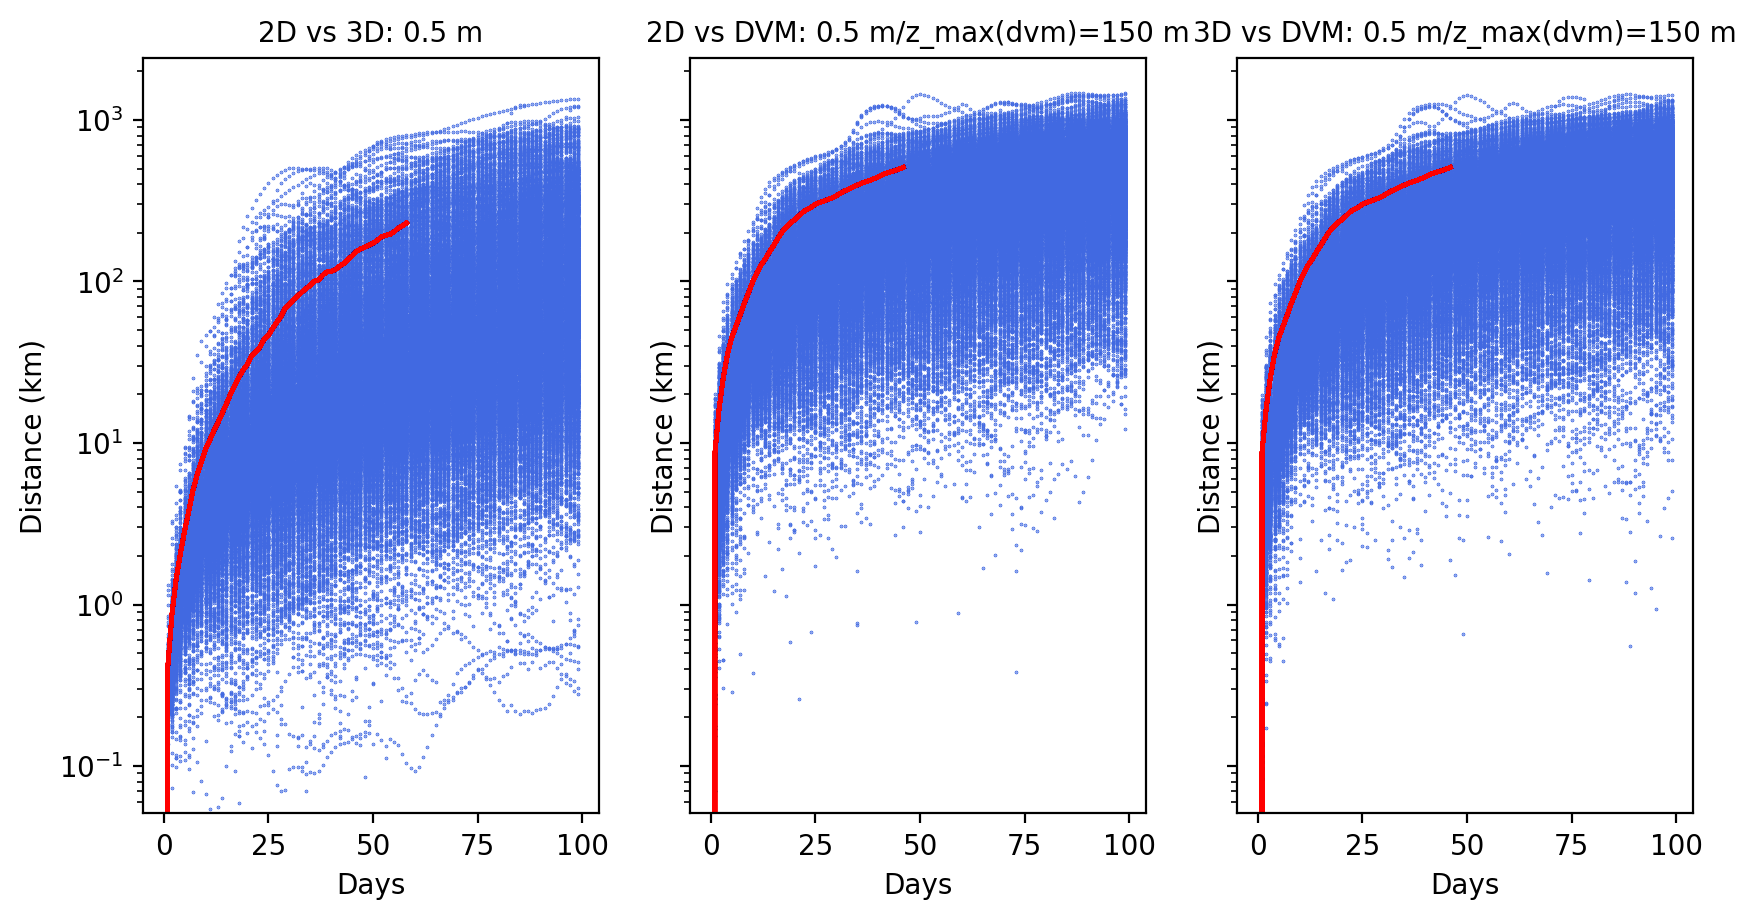

In [13]:
custom_size=10
fig, ax = plt.subplots(ncols=3, nrows=1, dpi=200, figsize=(10, 5), sharey=True)
for i in range(100):
    ax[0].title.set_text('2D vs 3D: 0.5 m')
    ax[0].title.set_fontsize(10)
    ax[0].scatter(np.full((p_total), i), sep_array_1_2[:,i], s=0.1,c='royalblue', zorder=1)
    ax[0].plot(percentile_95_1_2, c='red',zorder=2)
    ax[0].set_ylabel('Distance (km)', fontsize=custom_size)
    ax[0].set_xlabel('Days', fontsize=custom_size)
    ax[0].set_yscale('log')

    ax[1].title.set_text('2D vs DVM: 0.5 m/z_max(dvm)=150 m')
    ax[1].title.set_fontsize(10)
    ax[1].scatter(np.full((p_total), i), sep_array_1_3[:,i], s=0.1,c='royalblue', zorder=1)
    ax[1].plot(percentile_95_1_3, c='red',zorder=2)
    ax[1].set_ylabel('Distance (km)', fontsize=custom_size)
    ax[1].set_xlabel('Days', fontsize=custom_size)
    ax[1].set_yscale('log')

    ax[2].title.set_text('3D vs DVM: 0.5 m/z_max(dvm)=150 m')
    ax[2].title.set_fontsize(10)
    ax[2].scatter(np.full((p_total), i), sep_array_2_3[:,i], s=0.1,c='royalblue', zorder=1)
    ax[2].plot(percentile_95_1_3, c='red',zorder=2)
    ax[2].set_ylabel('Distance (km)', fontsize=custom_size)
    ax[2].set_xlabel('Days', fontsize=custom_size)
    ax[2].set_yscale('log')



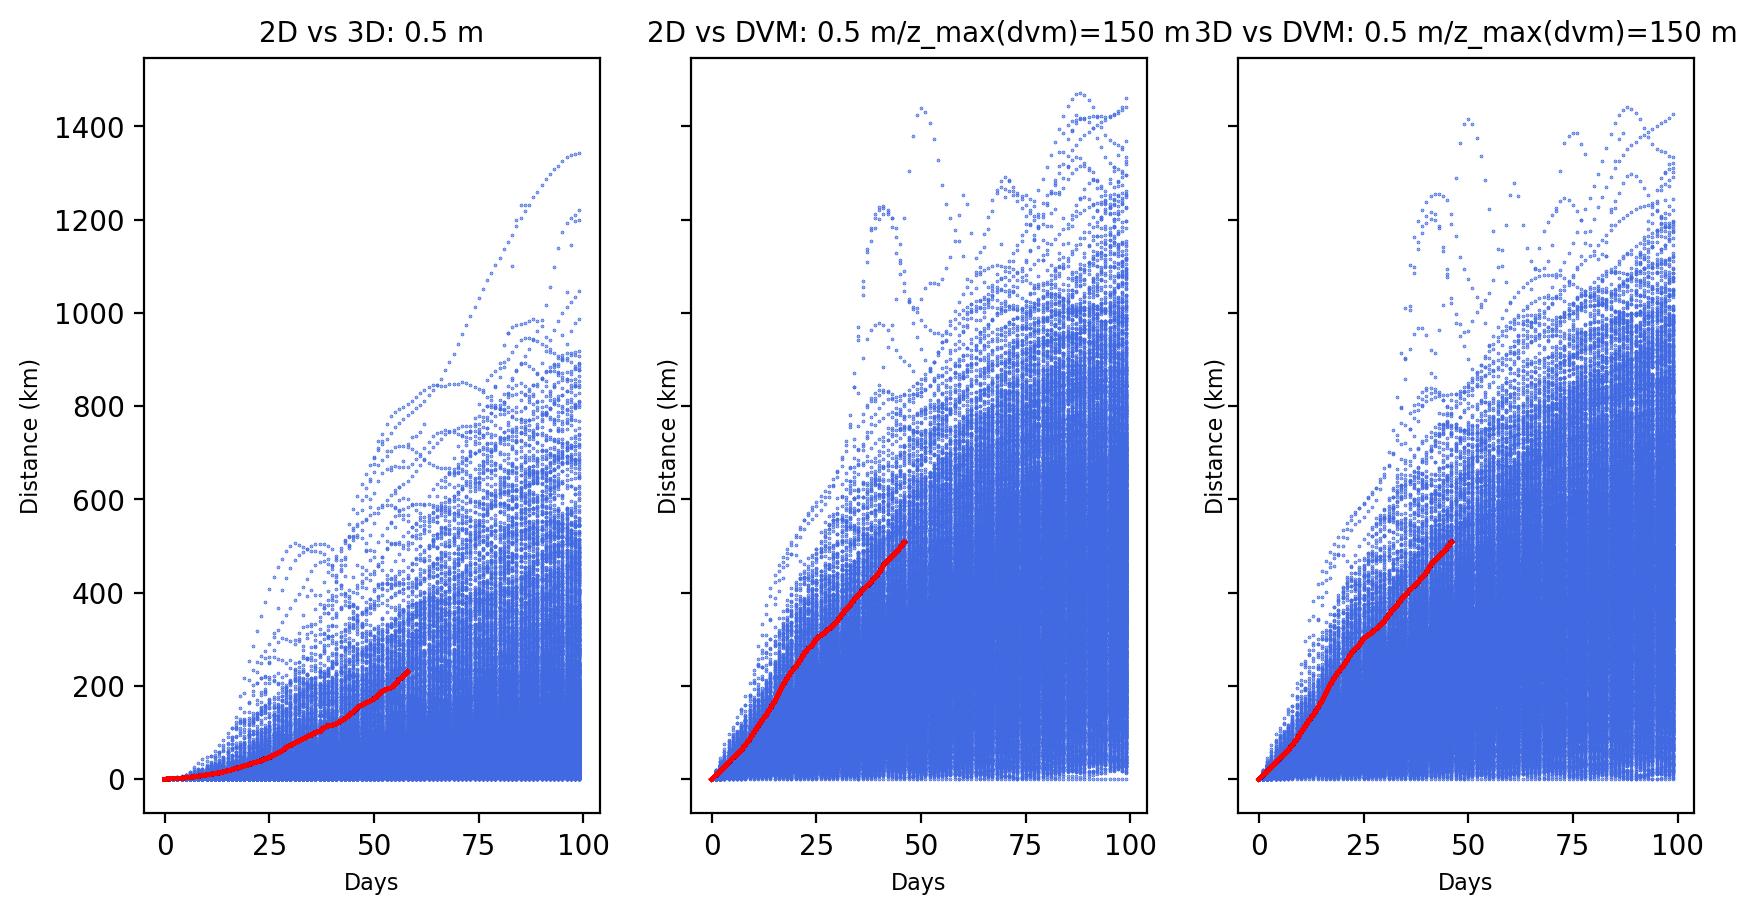

In [14]:
custom_size=8
fig, ax = plt.subplots(ncols=3, nrows=1, dpi=200, figsize=(10, 5), sharey=True)
for i in range(100):
    ax[0].title.set_text('2D vs 3D: 0.5 m')
    ax[0].title.set_fontsize(10)
    ax[0].scatter(np.full((p_total), i), sep_array_1_2[:,i], s=0.1,c='royalblue', zorder=1)
    ax[0].plot(percentile_95_1_2, c='red',zorder=2)
    ax[0].set_ylabel('Distance (km)', fontsize=custom_size)
    ax[0].set_xlabel('Days', fontsize=custom_size)

    ax[1].title.set_text('2D vs DVM: 0.5 m/z_max(dvm)=150 m')
    ax[1].scatter(np.full((p_total), i), sep_array_1_3[:,i], s=0.1,c='royalblue', zorder=1)
    ax[1].plot(percentile_95_1_3, c='red',zorder=2)
    ax[1].set_ylabel('Distance (km)', fontsize=custom_size)
    ax[1].set_xlabel('Days', fontsize=custom_size)
    ax[1].title.set_fontsize(10)

    ax[2].title.set_text('3D vs DVM: 0.5 m/z_max(dvm)=150 m')
    ax[2].scatter(np.full((p_total), i), sep_array_2_3[:,i], s=0.1,c='royalblue', zorder=1)
    ax[2].plot(percentile_95_1_3, c='red',zorder=2)
    ax[2].set_ylabel('Distance (km)', fontsize=custom_size)
    ax[2].set_xlabel('Days', fontsize=custom_size)
    ax[2].title.set_fontsize(10)

<h2> Plot time when particles cross threshold distance of delta-to start with one grid cell.

In [16]:
np.nanmax(sep_array_1_2, axis=0)

array([0.00000000e+00, 1.32340127e+00, 3.29093016e+00, 5.44928948e+00,
       7.37667159e+00, 9.49782321e+00, 1.47428680e+01, 2.53157566e+01,
       3.49690556e+01, 4.27284926e+01, 4.67575602e+01, 4.96591699e+01,
       6.00627652e+01, 7.24508930e+01, 8.42089204e+01, 9.79193037e+01,
       1.09745720e+02, 1.33607661e+02, 1.78438338e+02, 2.17712516e+02,
       2.52852226e+02, 2.86108615e+02, 3.18181631e+02, 3.48937038e+02,
       3.79059039e+02, 4.08144015e+02, 4.34415987e+02, 4.55902138e+02,
       4.73030328e+02, 4.88358523e+02, 5.00376186e+02, 5.06585655e+02,
       5.02654582e+02, 4.97950714e+02, 4.94275998e+02, 4.99178871e+02,
       5.03477299e+02, 5.04207429e+02, 5.04204479e+02, 5.00247077e+02,
       4.92648720e+02, 4.79161200e+02, 4.95855102e+02, 5.11898502e+02,
       5.46701831e+02, 5.78545504e+02, 6.06225450e+02, 6.32139787e+02,
       6.54802327e+02, 6.74082643e+02, 6.90398266e+02, 7.25491510e+02,
       7.40335500e+02, 7.61881973e+02, 7.77783789e+02, 7.88343943e+02,
      

In [17]:
delta_d = 111 # (approximately one grid cell separation)
def threshold_days(array, delta_d):
    def delta_value_index(row, tc):
        search = np.where(row>=tc)[0]
        if search.size>0:
            return search[0]
        return 104.0 # masking value-  not crossed in 100 days value just one bin higher 

    days=np.empty((array.shape[0]))
    for i in range(array.shape[0]):
        days[i]=delta_value_index(array[i,:], delta_d)
    return days

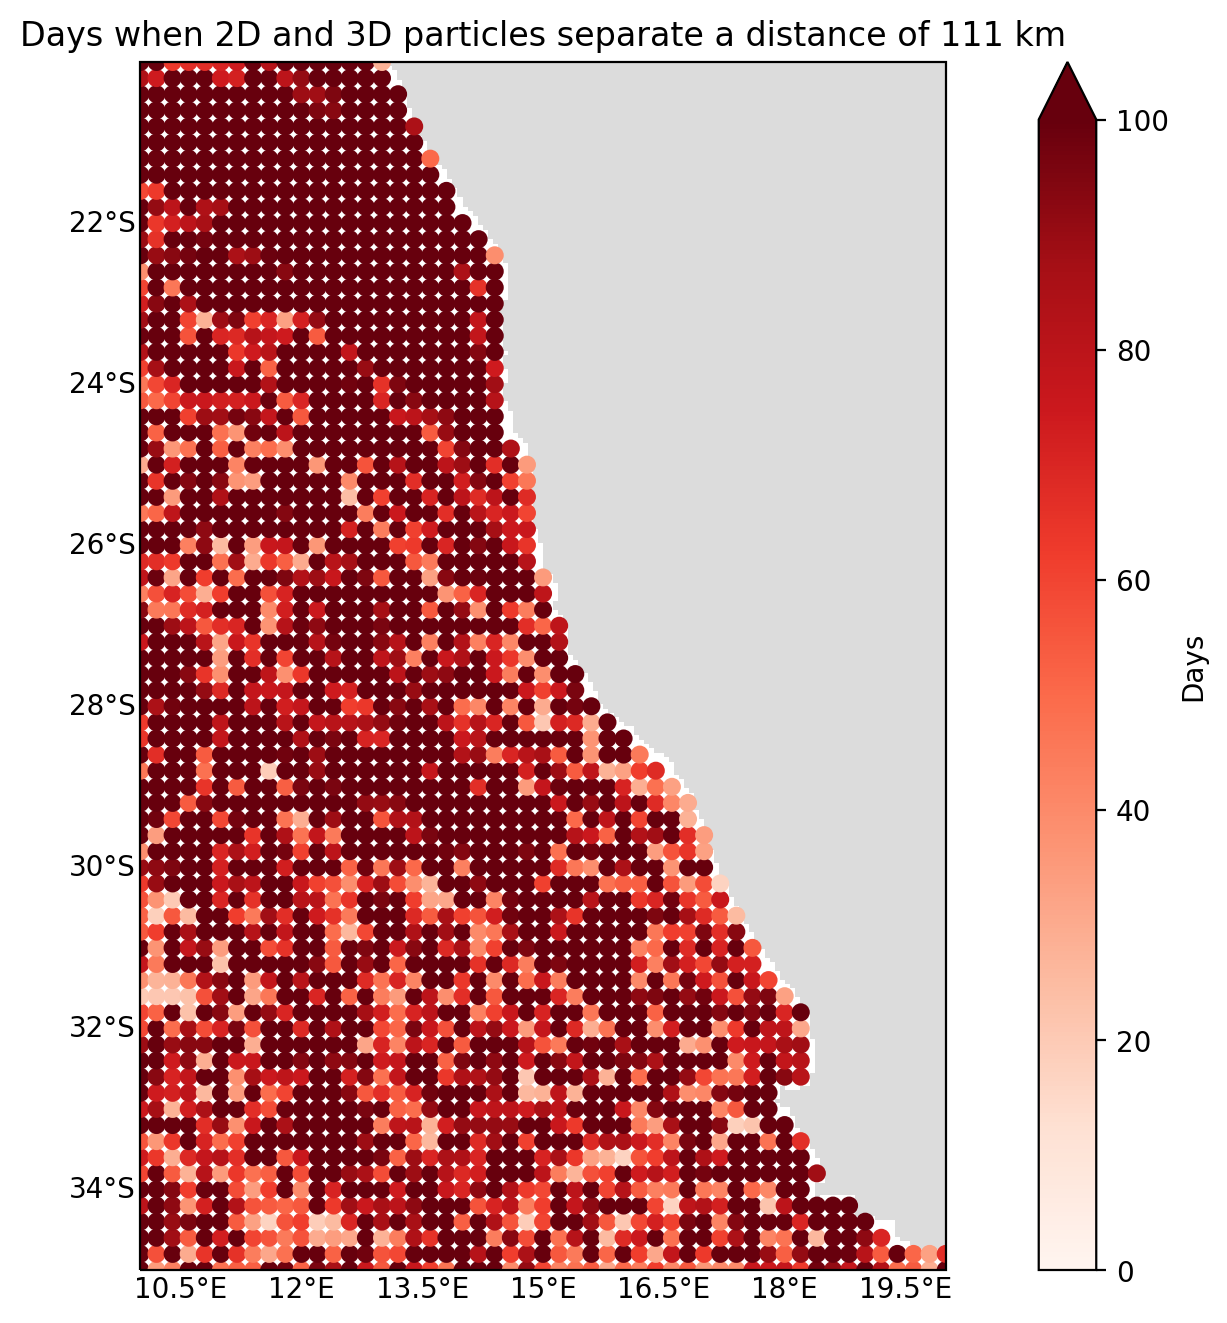

In [18]:

custom_size=10
fig = plt.figure(figsize=(12,8), dpi=200)
ax = plt.axes(projection=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True)
gl.xlines = False
gl.ylines = False
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': custom_size, 'color': 'k'}
gl.ylabel_style = {'size': custom_size, 'color': 'k'}
colormap = colors.ListedColormap(['gainsboro', 'white'])

ax.pcolormesh(mask_lon[0, 1249:1750, 1499:], mask_lat[0, 1249:1750, 1499:], mask_land[0,0, 1250:1750, 1500:], cmap=colormap)
ax.set_xlim(10, 20)
ax.set_ylim(-35, -20)
# ax.set_xlim(12,16)
# ax.set_ylim(-29,-25)
plt.title("Days when 2D and 3D particles separate a distance of {0} km".format(delta_d))
im=ax.scatter(ds1['lon'][:, 0], ds1['lat'][:, 0], c= threshold_days(sep_array_1_2, delta_d), s=30, cmap='Reds', vmin=0, vmax=100)
cbar=fig.colorbar(im, ax=ax, label='Days', extend='max')

plt.show()

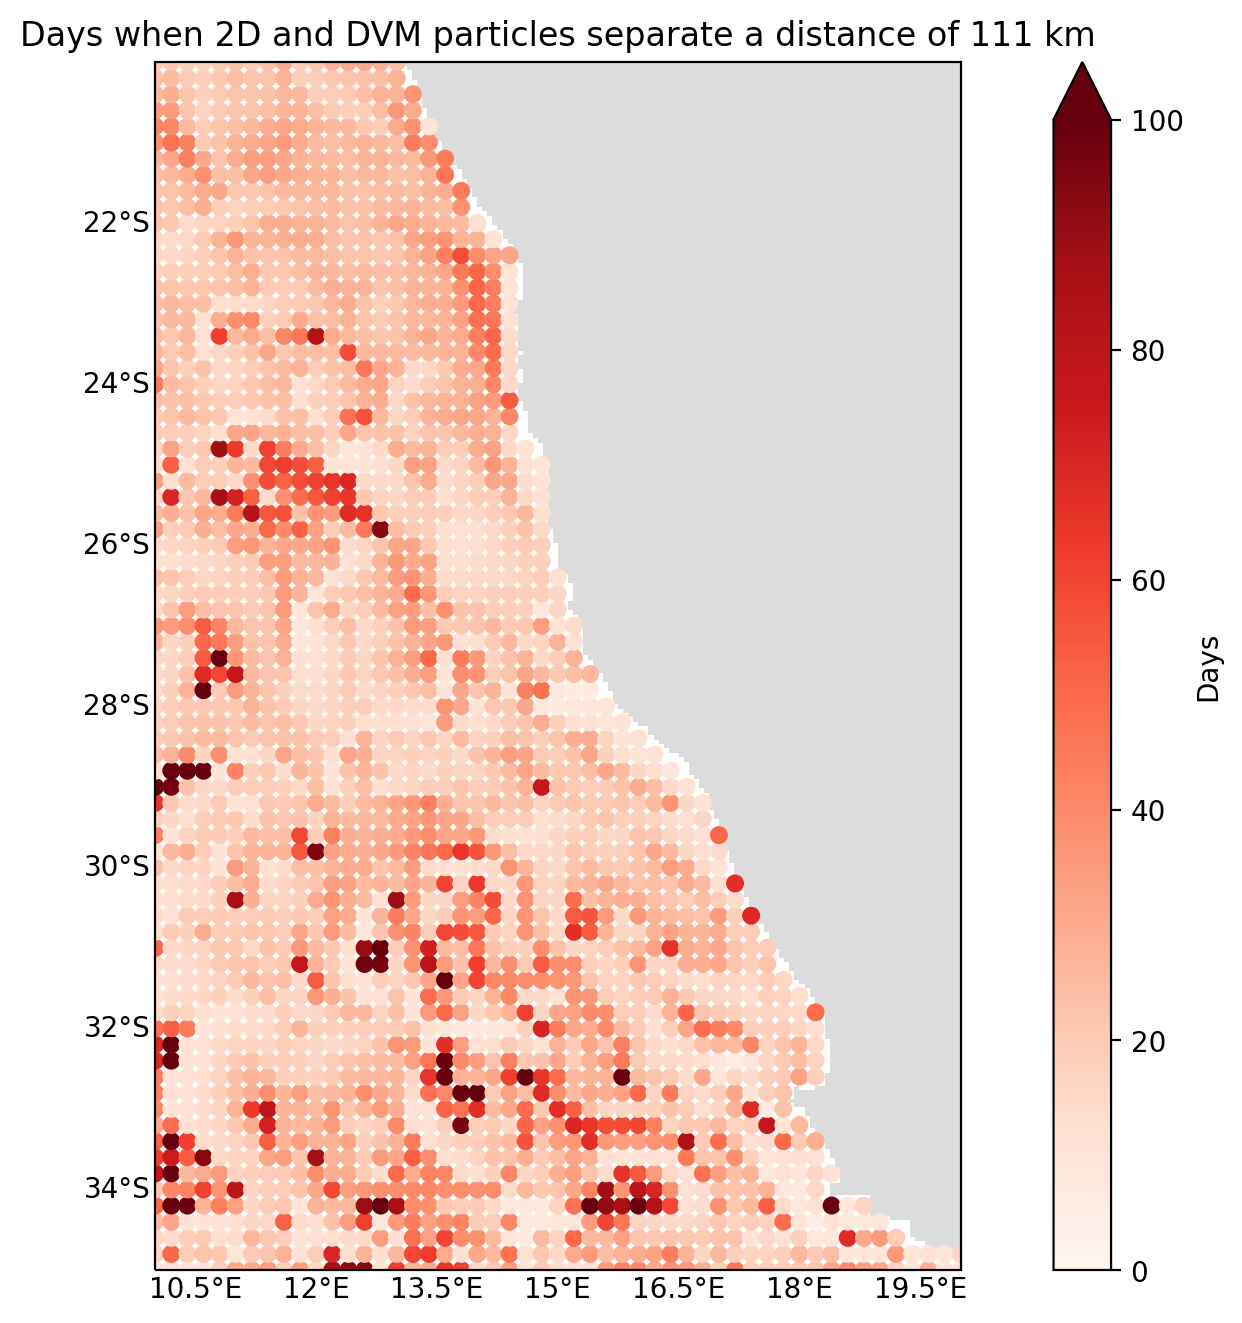

In [19]:
custom_size=10
fig = plt.figure(figsize=(12,8), dpi=200)
ax = plt.axes(projection=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True)
gl.xlines = False
gl.ylines = False
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': custom_size, 'color': 'k'}
gl.ylabel_style = {'size': custom_size, 'color': 'k'}
colormap = colors.ListedColormap(['gainsboro', 'white'])

ax.pcolormesh(mask_lon[0, 1249:1750, 1499:], mask_lat[0, 1249:1750, 1499:], mask_land[0,0, 1250:1750, 1500:], cmap=colormap)
ax.set_xlim(10, 20)
ax.set_ylim(-35, -20)
# ax.set_xlim(12,16)
# ax.set_ylim(-29,-25)
plt.title("Days when 2D and DVM particles separate a distance of {0} km".format(delta_d))

im=ax.scatter(ds1['lon'][:, 0], ds1['lat'][:, 0], c= threshold_days(sep_array_1_3, delta_d), s=30, cmap='Reds', vmin=0, vmax=100)
cbar=fig.colorbar(im, ax=ax, label='Days', extend='max')

plt.show()

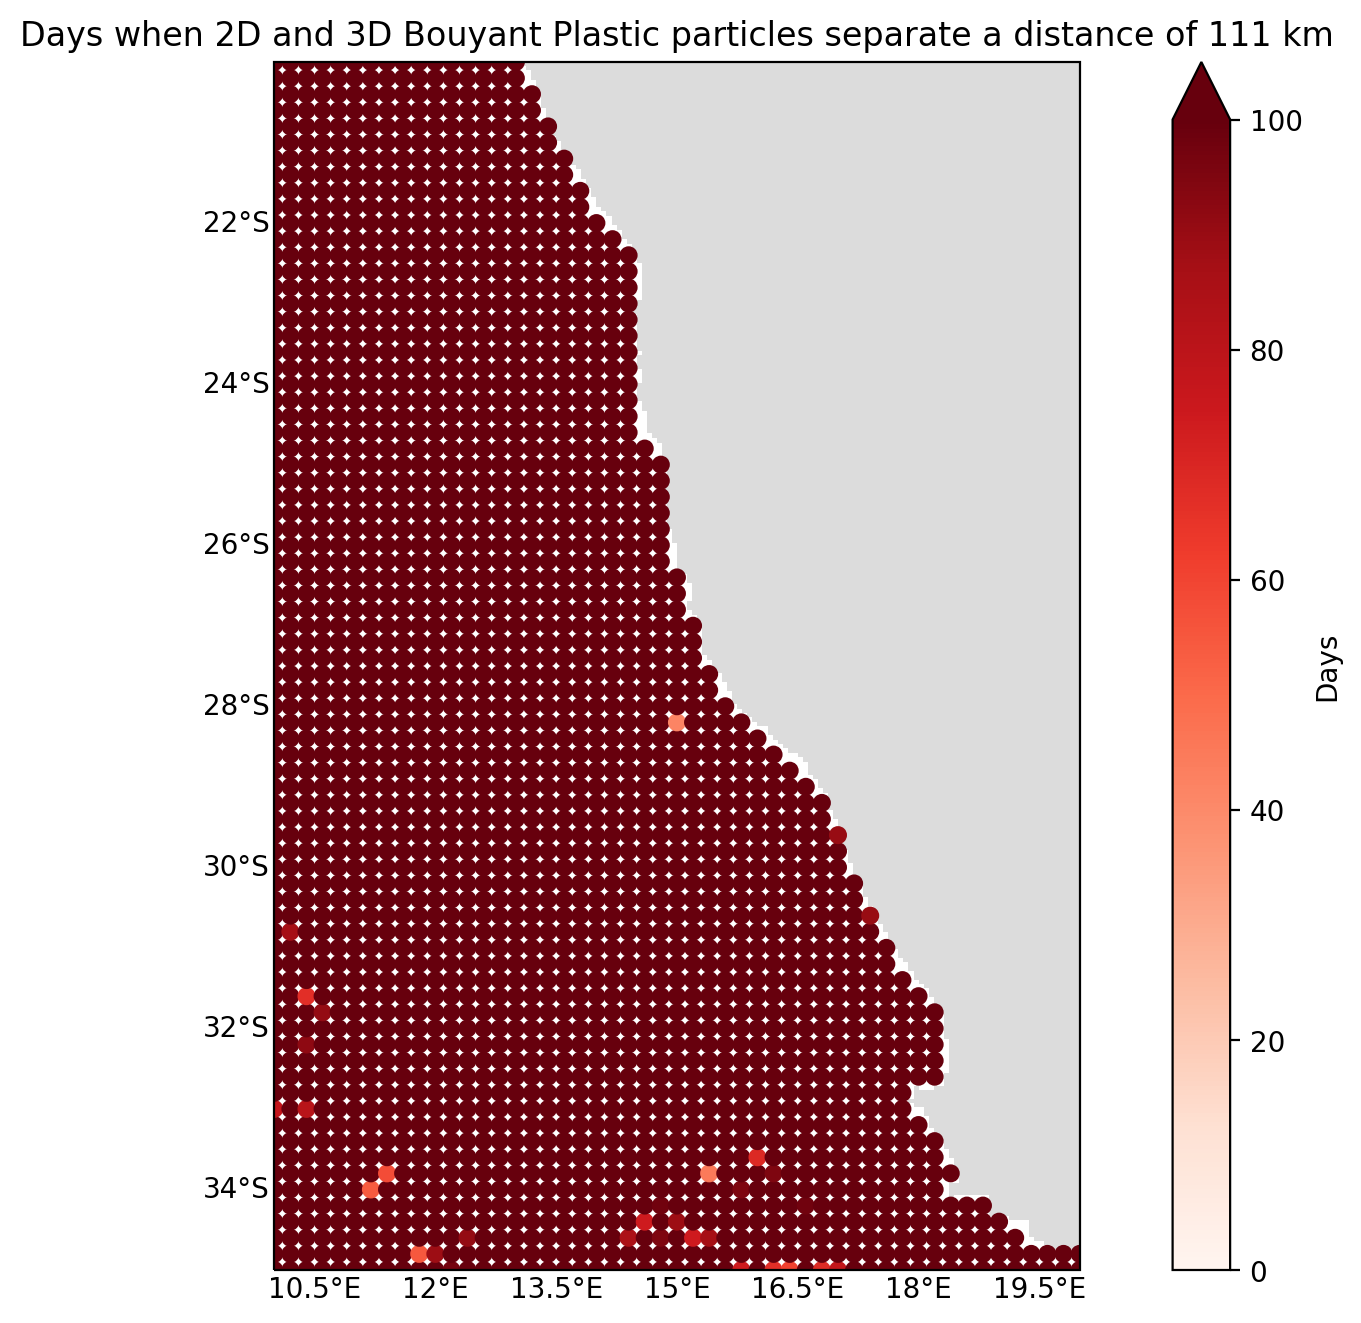

In [20]:
custom_size=10
fig = plt.figure(figsize=(12,8), dpi=200)
ax = plt.axes(projection=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True)
gl.xlines = False
gl.ylines = False
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': custom_size, 'color': 'k'}
gl.ylabel_style = {'size': custom_size, 'color': 'k'}
colormap = colors.ListedColormap(['gainsboro', 'white'])

ax.pcolormesh(mask_lon[0, 1249:1750, 1499:], mask_lat[0, 1249:1750, 1499:], mask_land[0,0, 1250:1750, 1500:], cmap=colormap)
ax.set_xlim(10, 20)
ax.set_ylim(-35, -20)
# ax.set_xlim(12,16)
# ax.set_ylim(-29,-25)
plt.title("Days when 2D and 3D Bouyant Plastic particles separate a distance of {0} km".format(delta_d))

im=ax.scatter(ds1['lon'][:, 0], ds1['lat'][:, 0], c= threshold_days(sep_array_1_4, delta_d), s=30, cmap='Reds', vmin=0, vmax=100)
cbar=fig.colorbar(im, ax=ax, label='Days', extend='max')

plt.show()

In [21]:
bins=np.arange(0,106,5)
bins

array([  0,   5,  10,  15,  20,  25,  30,  35,  40,  45,  50,  55,  60,
        65,  70,  75,  80,  85,  90,  95, 100, 105])

DescribeResult(nobs=2329, minmax=(17.0, 104.0), mean=86.3327608415629, variance=553.6697209397718, skewness=-1.1051622611839023, kurtosis=-0.012153954508152598)


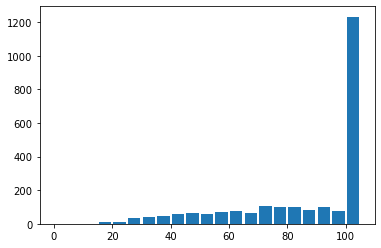

In [22]:
days_1_2 =threshold_days(sep_array_1_2, delta_d)
print(stats.describe(days_1_2, axis= None, nan_policy='omit'))

count, _, _ = plt.hist(days_1_2, bins=bins, rwidth=0.85)
pdf_1_2 = count/np.sum(count)
cdf_1_2 = np.cumsum(pdf_1_2)

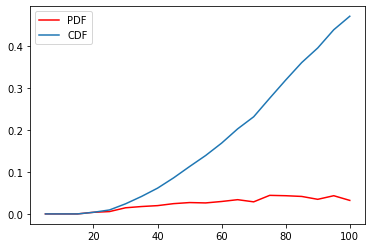

In [23]:
plt.plot(bins[1:-1], pdf_1_2[:-1], color="red", label="PDF")
plt.plot(bins[1:-1], cdf_1_2[:-1], label="CDF")
plt.legend()

<h3> Plot the CDFs with different delta_d setting

In [24]:
def get_diff_CDF(array, delta_d, bins):
    diff = threshold_days(array, delta_d)
    print(stats.describe(diff, axis= None)) #, nan_policy='omit'
    count, _ = np.histogram(diff, bins=bins)

    pdf = count/np.sum(count)
    cdf = np.cumsum(pdf)
    return cdf, pdf

DescribeResult(nobs=2329, minmax=(17.0, 104.0), mean=86.3327608415629, variance=553.6697209397718, skewness=-1.1051622611839023, kurtosis=-0.012153954508152598)
DescribeResult(nobs=2329, minmax=(5.0, 104.0), mean=26.620867325032204, variance=256.2483788006887, skewness=2.384339488203721, kurtosis=7.162914475476036)


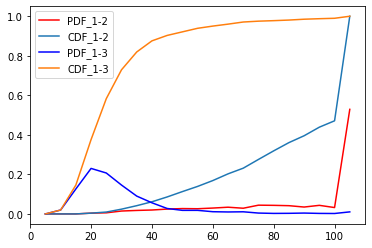

In [25]:
delta_new = 111 
cdf1,pdf1 = get_diff_CDF(sep_array_1_2, delta_new, bins)
cdf2,pdf2= get_diff_CDF(sep_array_1_3, delta_new, bins)

plt.plot(bins[1:], pdf1, color="red", label="PDF_1-2")
plt.plot(bins[1:], cdf1, label="CDF_1-2")
plt.plot(bins[1:], pdf2, color="blue", label="PDF_1-3")
plt.plot(bins[1:], cdf2, label="CDF_1-3")

plt.legend()


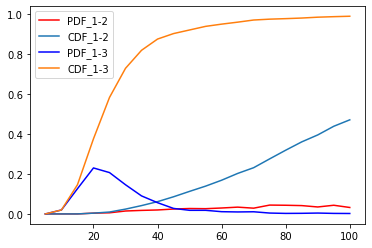

In [26]:
plt.plot(bins[1:-1], pdf1[:-1], color="red", label="PDF_1-2")
plt.plot(bins[1:-1], cdf1[:-1], label="CDF_1-2")
plt.plot(bins[1:-1], pdf2[:-1], color="blue", label="PDF_1-3")
plt.plot(bins[1:-1], cdf2[:-1], label="CDF_1-3")
plt.legend()

<h3> sensitivity to delta

DescribeResult(nobs=2329, minmax=(3.0, 104.0), mean=16.232288535852298, variance=105.03751370365288, skewness=4.04344285283768, kurtosis=25.568965212258693)
DescribeResult(nobs=2329, minmax=(1.0, 104.0), mean=2.286818376985831, variance=5.759624280143241, skewness=32.876000141210135, kurtosis=1383.9646331613296)
DescribeResult(nobs=2329, minmax=(1.0, 104.0), mean=2.4023185916702445, variance=5.889187061685988, skewness=31.69402765035313, kurtosis=1317.5490001497478)
DescribeResult(nobs=2329, minmax=(6.0, 104.0), mean=28.298840704164878, variance=255.03436721215687, skewness=1.865372965192002, kurtosis=5.076000644124404)
DescribeResult(nobs=2329, minmax=(1.0, 104.0), mean=3.7574066122799485, variance=6.891724542928767, skewness=24.211714334810278, kurtosis=911.5238299281195)
DescribeResult(nobs=2329, minmax=(1.0, 104.0), mean=3.9085444396736797, variance=7.012680397616192, skewness=23.484577604036453, kurtosis=875.0039349565557)
DescribeResult(nobs=2329, minmax=(12.0, 104.0), mean=72.24

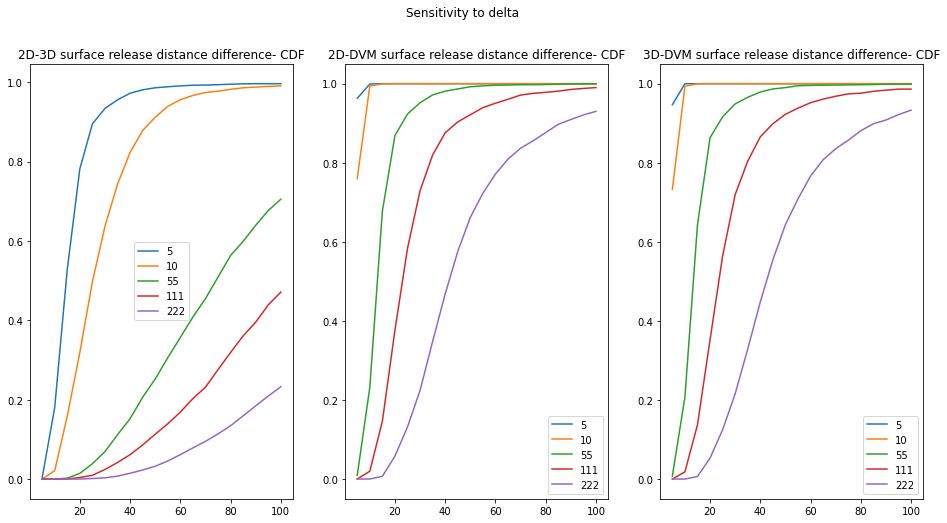

In [27]:
deltas=[5, 10, 55, 111, 222]
fig, ax = plt.subplots(figsize=(16,8), nrows=1, ncols=3)
fig.suptitle('Sensitivity to delta')
for d in deltas:
    cdf1,_ = get_diff_CDF(sep_array_1_2, d, bins)
    ax[0].plot(bins[1:-1], cdf1[:-1], label=d)

    cdf2,_ = get_diff_CDF(sep_array_1_3, d, bins)
    ax[1].plot(bins[1:-1], cdf2[:-1], label=d)
     
    cdf3,_ = get_diff_CDF(sep_array_2_3, d, bins)
    ax[2].plot(bins[1:-1], cdf3[:-1], label=d)

ax[0].set_title("2D-3D surface release distance difference- CDF")
ax[0].legend()  
ax[1].set_title("2D-DVM surface release distance difference- CDF")
ax[1].legend() 
ax[2].set_title("3D-DVM surface release distance difference- CDF")
ax[2].legend() 